<a href="https://colab.research.google.com/github/data-science-and-machine-learning/amazon-fine-food-reviews-naive-bayes/blob/master/Amazon_Fine_Food_Reviews_Analysis_NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive/')
files.upload()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mriduleecs","key":"c7aead406d827f0104c9072466c6fac6"}'}

In [3]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip -d amazon-fine-food-reviews-data


100% 250M/251M [00:03<00:00, 89.8MB/s]
100% 251M/251M [00:03<00:00, 84.1MB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: amazon-fine-food-reviews-data/Reviews.csv  
  inflating: amazon-fine-food-reviews-data/database.sqlite  
  inflating: amazon-fine-food-reviews-data/hashes.txt  


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews-data/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY Time Asc""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
#Deduplication of entries
print(filtered_data.shape)
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(525814, 10)
(364171, 10)


In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
You have no idea how many salchichon sandwiches I consumed while in Spain. Neither do I but it was a lot. Salchichon is somewhat like a hard salami but milder and less greasy. This particular product is pretty close to the salchichones I had in Spain. I prefer salchichon to chorizo for sandwiches but I prefer chorizo for eating as-is. Now someone just needs to open a good bakery around here that makes a good so-called "french" bread like the ones I had in Spain.
For those on a raw diet, this product is one of the best.  It is a simple snack (made with only two ingredients; dates and cashews), with no preservatives.  

In [10]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [11]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
You have no idea how many salchichon sandwiches I consumed while in Spain. Neither do I but it was a lot. Salchichon is somewhat like a hard salami but milder and less greasy. This particular product is pretty close to the salchichones I had in Spain. I prefer salchichon to chorizo for sandwiches but I prefer chorizo for eating as-is. Now someone just needs to open a good bakery around here that makes a good so-called "french" bread like the ones I had in Spain.
For those on a raw diet, this product is one of the best.  It is a simple snack (made with only two ingredients; dates and cashews), with no preservatives.  

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

For those on a raw diet, this product is one of the best.  It is a simple snack (made with only two ingredients; dates and cashews), with no preservatives.  Even if you are not a raw foodist, this bar is a healthy snack to be enjoyed by all.  I even convinced by 83 year-old father to try one and he is hooked!


In [14]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [15]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

For those on a raw diet this product is one of the best It is a simple snack made with only two ingredients dates and cashews with no preservatives Even if you are not a raw foodist this bar is a healthy snack to be enjoyed by all I even convinced by 83 year old father to try one and he is hooked 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
import nltk
sno = nltk.stem.SnowballStemmer('english')
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(sno.stem(e.lower()) for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    

100%|██████████| 364171/364171 [07:15<00:00, 835.47it/s]


In [18]:
preprocessed_reviews[1500]

'raw diet product one best simpl snack made two ingredi date cashew no preserv even not raw foodist bar healthi snack enjoy even convinc year old father tri one hook'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

Split done
Vectorization done
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   10.1s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  55 out of  55 | elapsed:   33.2s finished


Gridsearch done


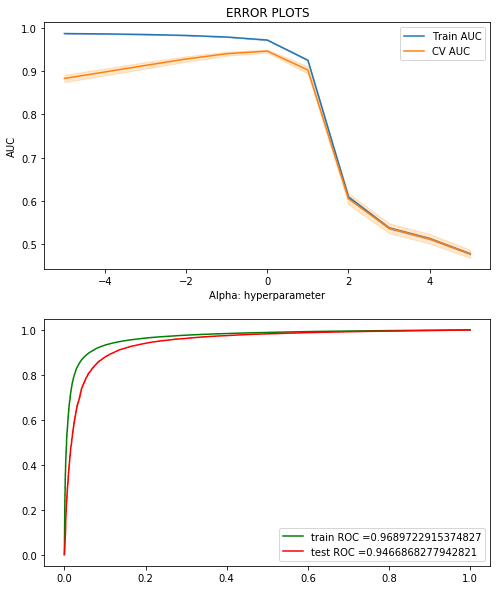


==CONCLUSION==


Best Classifier Score : {'alpha': 1.0}
Best Estimator : MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True)

AUC Score: 0.9458656584075754

Train confusion matrix: 
[[ 41214   3361]
 [ 21330 225431]]

Test confusion matrix: 
[[10994  1541]
 [ 6021 54279]]

Test Sensitivity or True Positive Rate: 0.65
Test Specificity or False Negative Rate: 0.97


In [66]:
# Please write all the code with proper documentation
# Motivation: To find the best hyperparameter value where AUC is Maximum
# We will check alpha values between 0.00001 to 
# Slicing training, test  and cv data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import time
import numpy as np
import multiprocessing

powers = list(np.arange(-5.0, 6.0, 1))
alpha_list = (list(np.power(([10]*len(powers)), powers)))
x_train, x_test, y_train, y_test= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.20, shuffle= False, stratify= None)
jobs= multiprocessing.cpu_count()
print('Split done')

vectorizer= CountVectorizer(ngram_range=(1,2), min_df=10)
train= vectorizer.fit_transform(x_train)
test= vectorizer.transform(x_test)
print('Vectorization done')

model= MultinomialNB(fit_prior= True, class_prior = [0.5, 0.5])
params= {
    'alpha': alpha_list  
}


score= GridSearchCV(model, params, cv= 5, scoring= 'roc_auc', verbose= 5, n_jobs= jobs, return_train_score= True)
score.fit(train, y_train)
print('Gridsearch done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_BOW= score.best_estimator_
AUC_BOW= score.best_score_
CM_BOW= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [67]:
# Please write all the code with proper documentation
# 10 Most important features from positive class

features = vectorizer.get_feature_names()
features_coef= pd.DataFrame()

#top= (features_coef.sort_index(ascending=False).head(10))
#print(top.values)
features_coef['features']= features
features_coef['coef']= best_model.feature_log_prob_[0]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 positive features: \n\n', features_coef.head(10))


Top 10 positive features: 

               coef
features          
not      -3.777096
tast     -4.732391
like     -4.817361
product  -4.990865
would    -5.159711
one      -5.270092
flavor   -5.295770
tri      -5.427197
good     -5.587490
coffe    -5.611672


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [68]:
# Please write all the code with proper documentation
features_coef['features']= features
features_coef['coef']= best_model.feature_log_prob_[1]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 negative features: \n\n', features_coef.head(10))

Top 10 negative features: 

               coef
features          
not      -4.212043
like     -4.932803
tast     -4.995448
good     -5.143631
flavor   -5.158262
love     -5.198045
great    -5.225639
use      -5.246376
one      -5.294513
product  -5.378398


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

Split done
Vectorization done
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done  55 out of  55 | elapsed:   28.2s finished


Gridsearch done


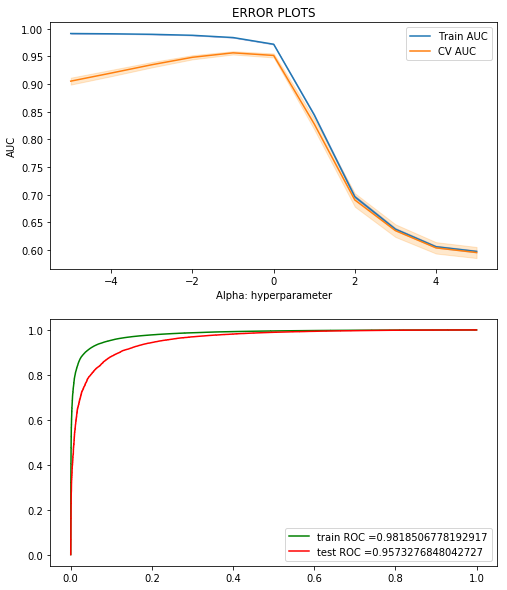


==CONCLUSION==


Best Classifier Score : {'alpha': 0.1}
Best Estimator : MultinomialNB(alpha=0.1, class_prior=[0.5, 0.5], fit_prior=True)

AUC Score: 0.9565903922999534

Train confusion matrix: 
[[ 42435   2140]
 [ 20243 226518]]

Test confusion matrix: 
[[11004  1531]
 [ 5945 54355]]

Test Sensitivity or True Positive Rate: 0.65
Test Specificity or False Negative Rate: 0.97


In [69]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Motivation: To find the best hyperparameter value where AUC is Maximum
# We will check alpha values between 0.00001 to 
# Slicing training, test  and cv data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import time
import numpy as np
import multiprocessing

powers = list(np.arange(-5.0, 6.0, 1))
alpha_list = (list(np.power(([10]*len(powers)), powers)))
x_train, x_test, y_train, y_test= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.20, shuffle= False, stratify= None)
jobs= multiprocessing.cpu_count()
print('Split done')

vectorizer= TfidfVectorizer(ngram_range=(1,2), min_df=10)
train= vectorizer.fit_transform(x_train)
test= vectorizer.transform(x_test)
print('Vectorization done')

model= MultinomialNB(fit_prior= True, class_prior = [0.5, 0.5])
params= {
    'alpha': alpha_list  
}


score= GridSearchCV(model, params, cv= 5, scoring= 'roc_auc', verbose= 5, n_jobs= jobs, return_train_score= True)
score.fit(train, y_train)
print('Gridsearch done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
EST_TFIDF= score.best_estimator_
AUC_TFIDF= score.best_score_
CM_TFIDF= TECM
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [70]:
# Please write all the code with proper documentation
# 10 Most important features from positive class

features = vectorizer.get_feature_names()
features_coef= pd.DataFrame()

#top= (features_coef.sort_index(ascending=False).head(10))
#print(top.values)
features_coef['features']= features
features_coef['coef']= best_model.feature_log_prob_[0]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 positive features: \n\n', features_coef.head(10))



Top 10 positive features: 

               coef
features          
not      -5.044004
tast     -5.672853
like     -5.813305
product  -5.848272
would    -5.987756
flavor   -6.177820
one      -6.190573
coffe    -6.211481
tri      -6.304283
order    -6.322203


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [71]:
# Please write all the code with proper documentation
features_coef['features']= features
features_coef['coef']= best_model.feature_log_prob_[1]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 negative features: \n\n', features_coef.head(10))

Top 10 negative features: 

               coef
features          
not      -5.574044
great    -5.926492
love     -5.929298
tast     -5.968901
like     -5.974633
good     -5.983612
tea      -6.014625
flavor   -6.042016
coffe    -6.095663
use      -6.134221


**FEATURE  ENGINEERING ADDING EXTRA FEATURES TO IMPROVE MODEL**

In [72]:
x_train, x_test, y_train, y_test= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.20, shuffle= False, stratify= None)
jobs= multiprocessing.cpu_count()
print('Split done')

vectorizer= CountVectorizer(ngram_range=(1,2), min_df=10)
train= vectorizer.fit_transform(x_train)

test= vectorizer.transform(x_test)
print('Vectorization done')

model= MultinomialNB(fit_prior= True, class_prior = [0.5, 0.5])
params= {
    'alpha': alpha_list  
}


Split done
Vectorization done


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    9.2s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  55 out of  55 | elapsed:   33.6s finished


Gridsearch done


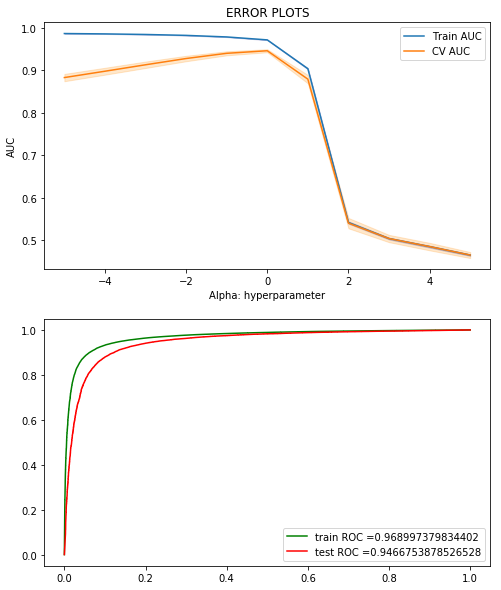


==CONCLUSION==


Best Classifier Score : {'alpha': 1.0}
Best Estimator : MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True)

AUC Score: 0.94587503121273

Train confusion matrix: 
[[ 41199   3376]
 [ 21279 225482]]

Test confusion matrix: 
[[10990  1545]
 [ 6007 54293]]

Test Sensitivity or True Positive Rate: 0.65
Test Specificity or False Negative Rate: 0.97


In [73]:
from scipy import sparse


score= GridSearchCV(model, params, cv= 5, scoring= 'roc_auc', verbose= 5, n_jobs= jobs, return_train_score= True)

length_review_train= [len(string.split()) for string in x_train]
length_review_test= [len(string.split()) for string in x_test]

train = sparse.hstack((train, np.transpose([length_review_train])))
test = sparse.hstack((test, np.transpose([length_review_test])))

score.fit(train, y_train)
print('Gridsearch done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_BOW_FE= score.best_estimator_
AUC_BOW_FE= score.best_score_
CM_BOW_FE= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

ADDING A WORDCOUNT FEATURE WITH TFIDF VECTOR

Split done
Vectorization done
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done  55 out of  55 | elapsed:   29.7s finished


Gridsearch done


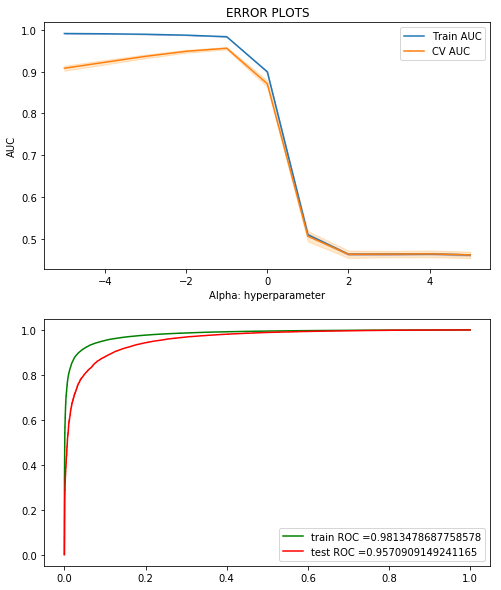


==CONCLUSION==


Best Classifier Score : {'alpha': 0.1}
Best Estimator : MultinomialNB(alpha=0.1, class_prior=[0.5, 0.5], fit_prior=True)

AUC Score: 0.9563207464291443

Train confusion matrix: 
[[ 42433   2142]
 [ 20584 226177]]

Test confusion matrix: 
[[11021  1514]
 [ 6058 54242]]

Test Sensitivity or True Positive Rate: 0.65
Test Specificity or False Negative Rate: 0.97


In [74]:
x_train, x_test, y_train, y_test= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.20, shuffle= False, stratify= None)
jobs= multiprocessing.cpu_count()
print('Split done')

vectorizer= TfidfVectorizer(ngram_range=(1,2), min_df=10)
train= vectorizer.fit_transform(x_train)

test= vectorizer.transform(x_test)
print('Vectorization done')

model= MultinomialNB(fit_prior= True, class_prior = [0.5, 0.5])
params= {
    'alpha': alpha_list  
}
from scipy import sparse


score= GridSearchCV(model, params, cv= 5, scoring= 'roc_auc', verbose= 5, n_jobs= jobs, return_train_score= True)

length_review_train= [len(string.split()) for string in x_train]
length_review_test= [len(string.split()) for string in x_test]

train = sparse.hstack((train, np.transpose([length_review_train])))
test = sparse.hstack((test, np.transpose([length_review_test])))

score.fit(train, y_train)
print('Gridsearch done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_TFIDF_FE= score.best_estimator_
AUC_TFIDF_FE= score.best_score_
CM_TFIDF_FE= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

# [6] Conclusions

+------------+--------------------------------------------+------------------------------------------------------------------+--------+
| Vectorizer |                   Model                    |                          Hyperparameter                          |  AUC   |
+------------+--------------------------------------------+------------------------------------------------------------------+--------+
|    BOW     |          Multinomial Naive Bayes           | MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True) | 0.9459 |
|   TFIDF    |          Multinomial Naive Bayes           | MultinomialNB(alpha=0.1, class_prior=[0.5, 0.5], fit_prior=True) | 0.9566 |
|    BOW     | Feature Engineered Multinomial Naive Bayes | MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5], fit_prior=True) | 0.9459 |
|   TFIDF    | Feature Engineered Multinomial Naive Bayes | MultinomialNB(alpha=0.1, class_prior=[0.5, 0.5], fit_prior=True) | 0.9563 |
+------------+----------------------------------

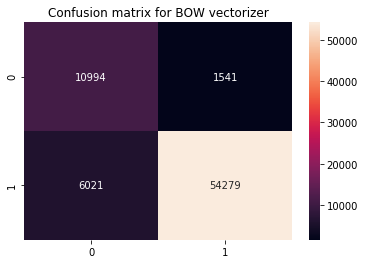

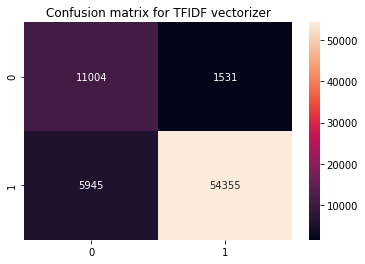

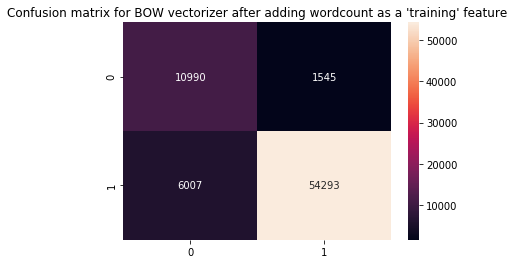

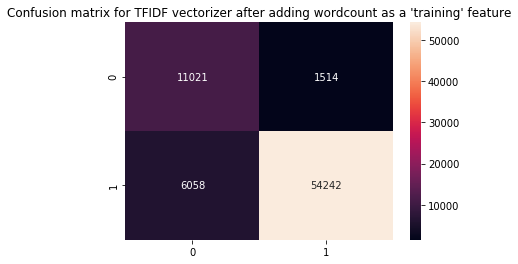

In [85]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
import seaborn as sns
x= PrettyTable(["Vectorizer", "Model", "Hyperparameter", "AUC"])

x.add_row(['BOW', 'Multinomial Naive Bayes', EST_BOW, '{:.4f}'.format(AUC_BOW)])
x.add_row(['TFIDF', 'Multinomial Naive Bayes', EST_TFIDF, '{:.4f}'.format(AUC_TFIDF)])
x.add_row(['BOW', 'Feature Engineered Multinomial Naive Bayes', EST_BOW_FE, '{:.4f}'.format(AUC_BOW_FE)])
x.add_row(['TFIDF', 'Feature Engineered Multinomial Naive Bayes', EST_TFIDF_FE, '{:.4f}'.format(AUC_TFIDF_FE)])

print(x)


ax= sns.heatmap(CM_BOW, annot=True, fmt="d")
ax.set_title('Confusion matrix for BOW vectorizer')
plt.show()

ax= sns.heatmap(CM_TFIDF, annot=True, fmt="d")
ax.set_title('Confusion matrix for TFIDF vectorizer')
plt.show()

ax= sns.heatmap(CM_BOW_FE, annot=True, fmt="d")
ax.set_title('Confusion matrix for BOW vectorizer after adding wordcount as a \'training\' feature')
plt.show()

ax= sns.heatmap(CM_TFIDF_FE, annot=True, fmt="d")
ax.set_title('Confusion matrix for TFIDF vectorizer after adding wordcount as a \'training\' feature')
plt.show()
